### MultiModal RAG for Advanced Video Processing with LlamaIndex & LanceDB

**Installing the packages/dependencies**

In [1]:
# !pip install pytubefix
# !pip install moviepy
# !pip install SpeechRecognition
# !pip install openai-whisper
# !pip install soundfile
# !pip install --upgrade llama-index llama-index-core
# !pip install llama-index-multi-modal-llms-gemini
# !pip install llama-index-vector-stores-lancedb
# !pip install pydub
# !pip install llama-index-embeddings-gemini
# !pip install matplotlib
# !pip install einops

**Importing the Package**

In [2]:
from pathlib import Path
from pytubefix import YouTube
from moviepy import VideoFileClip
import os

**Set the folders to store the data**

In [3]:
# SET CONFIG
video_url = "https://www.youtube.com/watch?v=d_qvLDhkg00"#"https://www.youtube.com/watch?v=d_qvLDhkg00"
output_video_path = "./video_data/"
output_folder = "./mixed_data/"
output_audio_path = "./mixed_data/output_audio.wav"

filepath = output_video_path + "input_vid.mp4"
Path(output_folder).mkdir(parents=True, exist_ok=True)

**Download the Video Using Pytubefix**

In [4]:
def download_video(url, output_path):
    """
    Download a video from a given url and save it to the output path.

    Parameters:
    url (str): The url of the video to download.
    output_path (str): The path to save the video to.

    Returns:
    dict: A dictionary containing the metadata of the video.
    """
   

    yt = YouTube(url)
    print(yt)
    metadata = {"Author": yt.author, "Title": yt.title, "Views": yt.views}
    yt.streams.get_highest_resolution().download(
        output_path=output_path, filename="input_vid.mp4"
    )
    return metadata

**Get Video Metadata**

In [5]:
metadata_str = str(download_video(video_url, output_video_path))

<pytubefix.__main__.YouTube object: videoId=d_qvLDhkg00>


In [6]:
print(metadata_str)

{'Author': '3Blue1Brown', 'Title': 'A pretty reason why Gaussian + Gaussian = Gaussian', 'Views': 914211}


**Turn video into images using moviepy**

In [7]:
def video_to_images(video_path, output_folder):
    """
    Convert a video to a sequence of images and save them to the output folder.

    Parameters:
    video_path (str): The path to the video file.
    output_folder (str): The path to the folder to save the images to.

    """
    clip = VideoFileClip(video_path)
    clip.write_images_sequence(
        os.path.join(output_folder, "frame%04d.png"), fps=0.2 #configure this for controlling frame rate.
    )

**Extract the Audio from Video using moviepy**

In [8]:
def video_to_audio(video_path, output_audio_path):
    """
    Convert a video to audio and save it to the output path.

    Parameters:
    video_path (str): The path to the video file.
    output_audio_path (str): The path to save the audio to.

    """
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)

**Convert the Audio into Text using speech recognition (whisper)**

In [9]:
import speech_recognition as sr

def audio_to_text(audio_path):
    """
    Convert an audio file to text.

    Parameters:
    audio_path (str): The path to the audio file.

    Returns:
    test (str): The text recognized from the audio.

    """
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path)

    with audio as source:
        # Record the audio data
        audio_data = recognizer.record(source)

        try:
            # Recognize the speech
            text = recognizer.recognize_whisper(audio_data)
        except sr.UnknownValueError:
            print("Speech recognition could not understand the audio.")
        except sr.RequestError as e:
            print(f"Could not request results from service; {e}")

    return text

**Calling the functions**

In [10]:
import os

video_to_images("./video_data/input_vid.mp4", output_folder)
video_to_audio(filepath, output_audio_path)
text_data = audio_to_text(output_audio_path)

with open(output_folder + "output_text.txt", "w") as file:
    file.write(text_data)
print("Text data saved to file")
file.close()
os.remove(output_audio_path)
print("Audio file removed")

MoviePy - Writing audio in ./mixed_data/output_audio.wav


MoviePy - Done.
Text data saved to file
Audio file removed


**Setting up Embedding Model**

In [11]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
from llama_index.embeddings.clip import ClipEmbedding

# # # # Initialize the ClipEmbedding model
# # # # Use the model name as specified by OpenAI's original implementation
clip_embed_model = ClipEmbedding(model_name="ViT-B/32")
bge_embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

# # # # Set this as your default image embed model in the LlamaIndex settings
# # # # This will be used when processing multimodal documents
Settings.image_embed_model = clip_embed_model
Settings.embed_model = bge_embed_model

**Setting Up LanceDB and creating the index on Documents**

In [48]:
# documents

In [12]:
#from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.vector_stores.lancedb import LanceDBVectorStore

text_store = LanceDBVectorStore(uri="lancedb", table_name="text_collection")
image_store = LanceDBVectorStore(uri="lancedb", table_name="image_collection")
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader(output_folder).load_data()

In [13]:
documents

[ImageDocument(id_='e4e50102-1cfc-4a15-a74c-e3f48d2e196a', embedding=None, metadata={'file_path': '/home/mayur/Documents/git-repo-with-ads/Explore-Libraries/video-rag/mixed_data/frame0000.png', 'file_name': 'frame0000.png', 'file_type': 'image/png', 'file_size': 18581, 'creation_date': '2025-12-12', 'last_modified_date': '2025-12-12'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=None, image_resource=MediaResource(embeddings=None, data=None, text=None, path=PosixPath('/home/mayur/Documents/git-repo-with-ads/Explore-Libraries/video-rag/mixed_data/frame0000.png'), url=None, mimetype='image/png'), audio_resource=None, video_resource=None, text_template='{metadata_str}\n\n{content}'),
 I

In [14]:
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

**Initializing Retriever from Index**

In [15]:
retriever_engine = index.as_retriever(
    similarity_top_k=5, image_similarity_top_k=5
)

**Define function to retrieve the results based on Query**

In [16]:
from llama_index.core.schema import ImageNode
from llama_index.core.response.notebook_utils import display_source_node


def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

In [17]:
query_str = """
Using examples from the video, explain all things covered regarding
the gaussian function
"""

In [18]:
img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str)
image_documents = SimpleDirectoryReader(
    input_dir=output_folder, input_files=img
).load_data()
context_str = "".join(txt)

2025-12-12 12:01:42,072 - INFO - query_type :, vector


2025-12-12 12:01:42,102 - INFO - query_type :, vector


**Node ID:** e9c6e05d-db4e-4a53-b616-ad33930a122f<br>**Similarity:** 0.619665265083313<br>**Text:** One common approach to proving this theorem involves two separate steps. The first step is to show that for all the different finite variance distributions you might start with, there exists a sing...<br>

**Node ID:** edf8bf4f-e6f9-4482-8e8f-b87966d77b37<br>**Similarity:** 0.619665265083313<br>**Text:** One common approach to proving this theorem involves two separate steps. The first step is to show that for all the different finite variance distributions you might start with, there exists a sing...<br>

In [19]:
import os
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

files = img

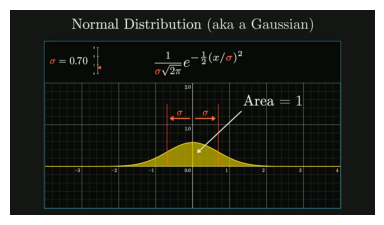

In [20]:
for num, x in enumerate(files):
    img = PIL.Image.open(x)
    plt.figure(figsize=(16, 18))
    plt.subplot(2,3,num+1)
    # plt.title(x.split('.')[0])
    plt.axis('off')
    plt.imshow(img)

In [21]:
qa_tmpl_str = (
    """
 Given the provided information, including relevant images and retrieved context from the video, \
 accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
"""
)

In [22]:
# from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from dotenv import load_dotenv

print(load_dotenv())

API_KEY = os.getenv('GEMINI_API_KEY')

# gemini_mm_llm = GeminiMultiModal(
#     model="models/gemini-2.0-flash", api_key=API_KEY, max_new_tokens=1500
# )

True


In [ ]:
# # response_1 =  gemini_mm_llm.complete(
#     prompt=qa_tmpl_str.format(context_str=context_str, query_str=query_str, metadata_str=metadata_str),
#     image_documents=image_documents,
# )

In [23]:
print(qa_tmpl_str.format(context_str=context_str, query_str=query_str, metadata_str=metadata_str))


 Given the provided information, including relevant images and retrieved context from the video,  accurately and precisely answer the query without any additional prior knowledge.
"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.
"
    "---------------------
"
    "Context: One common approach to proving this theorem involves two separate steps. The first step is to show that for all the different finite variance distributions you might start with, there exists a single universal shape that this process of repeated convolutions tends towards. This step is actually pretty technical, it goes a little beyond what I want to talk about here. You often use these objects called moment generating functions that gives you a very abstract argument that there must be some universal shape, but it doesn't make any claim about what that particular shape is, just that everything in this big family is tending towards a single point in the space of distribu

In [24]:
from llama_index.llms.gemini import Gemini
from llama_index.core.llms import ChatMessage, ImageBlock

gemini_pro = Gemini(model_name="models/gemini-2.5-flash")
msg = ChatMessage(qa_tmpl_str.format(context_str=context_str, query_str=query_str, metadata_str=metadata_str))

for img_url in image_documents:
    msg.blocks.append(ImageBlock(path=img_url.image_path))

/home/mayur/rag_opensearch/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.12) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
/tmp/ipykernel_254745/2724882667.py:4: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  gemini_pro = Gemini(model_name="models/gemini-2.5-flash")


In [25]:
response_multi = gemini_pro.chat(messages=[msg])

In [26]:
print(response_multi.message.content)

Based on the provided information, here are all things covered regarding the Gaussian function:

1.  **Definition and Appearance:**
    *   The Gaussian function is also known as the **Normal Distribution** (as seen in the image title).
    *   Its mathematical formula is given as `(1 / (σ√2π)) * e^(-1/2 * (x/σ)^2)`.
    *   It is represented graphically as a **bell-shaped curve** (as depicted in the image).
    *   The parameter `σ` (sigma) influences the spread of the distribution; for the example shown in the image, `σ = 0.70`.

2.  **Properties as a Probability Distribution:**
    *   The **area under the curve is equal to 1** ("Area = 1" is explicitly labeled in the image), indicating that it is a probability distribution.

3.  **Role in the Central Limit Theorem (CLT):**
    *   The Gaussian is the **single universal shape** that the process of repeated convolutions tends towards for all finite variance distributions.
    *   It is a **fixed point** under convolution: "the convol